In [1]:
import os
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import random
from collections import *
import torch
import torch.nn as nn
import torch.optim as optim

from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
from torchvision.transforms import ToTensor
from tqdm import tqdm

In [2]:
data_parent = 'C:/Users/user/Desktop/AdienceBenchmarkGenderAndAgeClassification/'
print(os.listdir(data_parent))

['AdienceBenchmarkGenderAndAgeClassification', 'faces', 'fold_0_data.txt', 'fold_1_data.txt', 'fold_2_data.txt', 'fold_3_data.txt', 'fold_4_data.txt', '__MACOSX']


In [3]:
fold_0 = pd.read_csv(os.path.join(data_parent, 'fold_0_data.txt'), sep='\t')
fold_1 = pd.read_csv(os.path.join(data_parent, 'fold_1_data.txt'),sep='\t')
fold_2 = pd.read_csv(os.path.join(data_parent, 'fold_2_data.txt'),sep='\t')
fold_3 = pd.read_csv(os.path.join(data_parent, 'fold_3_data.txt'),sep='\t')
fold_4 = pd.read_csv(os.path.join(data_parent, 'fold_4_data.txt'),sep='\t')
total_data = pd.concat([fold_0, fold_1, fold_2, fold_3, fold_4], ignore_index=True)
total_data.head()

,user_id,original_image,face_id,age,gender,x,y,dx,dy,tilt_ang,fiducial_yaw_angle,fiducial_score
0,30601258@N03,10399646885_67c7d20df9_o.jpg,1,"(25, 32)",f,0,414,1086,1383,-115,30,17
1,30601258@N03,10424815813_e94629b1ec_o.jpg,2,"(25, 32)",m,301,105,640,641,0,0,94
2,30601258@N03,10437979845_5985be4b26_o.jpg,1,"(25, 32)",f,2395,876,771,771,175,-30,74
3,30601258@N03,10437979845_5985be4b26_o.jpg,3,"(25, 32)",m,752,1255,484,485,180,0,47
4,30601258@N03,11816644924_075c3d8d59_o.jpg,2,"(25, 32)",m,175,80,769,768,-75,0,34


In [4]:
age_mapping = [('(0, 2)', '0-2'), ('2', '0-2'), ('3', '0-2'), ('(4, 6)', '4-6'), ('(8, 12)', '8-13'), ('13', '8-13'), ('22', '15-20'), ('(8, 23)','15-20'), ('23', '25-32'), ('(15, 20)', '15-20'), ('(25, 32)', '25-32'), ('(27, 32)', '25-32'), ('32', '25-32'), ('34', '25-32'), ('29', '25-32'), ('(38, 42)', '38-43'), ('35', '38-43'), ('36', '38-43'), ('42', '48-53'), ('45', '38-43'), ('(38, 43)', '38-43'), ('(38, 42)', '38-43'), ('(38, 48)', '48-53'), ('46', '48-53'), ('(48, 53)', '48-53'), ('55', '48-53'), ('56', '48-53'), ('(60, 100)', '60+'), ('57', '60+'), ('58', '60+')]
age_mapping_dict = {each[0]: each[1] for each in age_mapping}

drop_labels = []
for idx, each in enumerate(total_data.age):
    if each == 'None':
        drop_labels.append(idx)
    else:
        total_data.age.loc[idx] = age_mapping_dict[each]
total_data = total_data.drop(labels=drop_labels, axis=0) #droped None values
total_data.age.value_counts(dropna=False)

C:\Users\user\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


25-32    5296
38-43    2776
0-2      2509
8-13     2292
4-6      2140
15-20    1792
48-53     916
60+       901
Name: age, dtype: int64

## 48세 미만의 data 12156개, 48세 이상의 data 1817개

## data 상당히 불균형하여 48세 미만 데이터 연령대별로 몇 개씩 랜덤으로 추출하여 균형 잡힌 데이터 생성

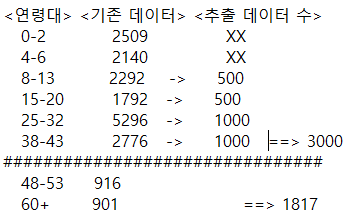

In [5]:
total_data = total_data.dropna()
total_data['full_path'] = total_data.apply(lambda x: os.path.join(data_parent, 'faces', str(x.user_id), 'coarse_tilt_aligned_face.' + str(x.face_id) + '.' + x.original_image), axis=1)
total_data.age.unique(), len(total_data.age.unique()), total_data.gender.unique()

(array(['25-32', '38-43', '4-6', '60+', '15-20', '48-53', '8-13', '0-2'],
       dtype=object),
 8,
 array(['f', 'm', 'u'], dtype=object))

In [6]:
age_map = {
    '0-2'  :100,
    '4-6'  :100,
    '8-13' :2,
    '15-20':3,
    '25-32':4,
    '38-43':5,
    '48-53':1,
    '60+'  :1
}

total_data.age=total_data.age.replace(age_map)

In [7]:
age_labels= total_data.age.values.tolist()
train_paths = total_data.full_path.values.tolist()

In [8]:
slist = list(zip(train_paths, age_labels))
slist[1][1]

4

In [9]:
list1 = []
list2 = []
list3 = []
list4 = []
list5 = []

In [10]:
for i in range(len(slist)):
    if slist[i][1] == 2:
        list2.append(slist[i])
    elif slist[i][1] == 3:
        list3.append(slist[i])
    elif slist[i][1] == 4:
        list4.append(slist[i])
    elif slist[i][1] == 5:
        list5.append(slist[i])
    elif slist[i][1] == 1:
        list1.append(slist[i])

In [11]:
random.seed(1234)
list2 = random.sample(list2, 500)
list3 = random.sample(list3, 500)
list4 = random.sample(list4, 1000)
list5 = random.sample(list5, 1000)

In [12]:
back = list2+list3+list4+list5

In [13]:
new_list = []
for i in range(len(back)):
    vlist = list(back[i])
    vlist[1] = 0
    new_list.append(tuple(vlist))

In [14]:
new_list = new_list+list1
random.seed(1234)
new_list = random.sample(new_list, len(new_list))

In [15]:
train_paths, age_labels = zip(*new_list)

In [16]:
train_split = 0.75
train_sample = int(train_split * len(new_list))
train_data = train_paths[:train_sample]
test_data = train_paths[train_sample:]

train_labels_age=age_labels[:train_sample]
test_labels_age=age_labels[train_sample:]
print("train data count:", len(train_data), len(train_labels_age))
print("test data count:", len(test_data), len(test_labels_age))

train data count: 3603 3603
test data count: 1202 1202


In [17]:
train_df = pd.DataFrame({'file_path' : train_data, 'age_label' : train_labels_age})
validation_df = pd.DataFrame({'file_path' : test_data, 'age_label' : test_labels_age})

In [18]:
train_df

,file_path,age_label
0,C:/Users/user/Desktop/AdienceBenchmarkGenderAn...,1
1,C:/Users/user/Desktop/AdienceBenchmarkGenderAn...,0
2,C:/Users/user/Desktop/AdienceBenchmarkGenderAn...,0
3,C:/Users/user/Desktop/AdienceBenchmarkGenderAn...,0
4,C:/Users/user/Desktop/AdienceBenchmarkGenderAn...,1
...,...,...
3598,C:/Users/user/Desktop/AdienceBenchmarkGenderAn...,0
3599,C:/Users/user/Desktop/AdienceBenchmarkGenderAn...,0
3600,C:/Users/user/Desktop/AdienceBenchmarkGenderAn...,1
3601,C:/Users/user/Desktop/AdienceBenchmarkGenderAn...,0


In [19]:
Counter(train_df['age_label'])

Counter({1: 1351, 0: 2252})

In [20]:
validation_df

,file_path,age_label
0,C:/Users/user/Desktop/AdienceBenchmarkGenderAn...,0
1,C:/Users/user/Desktop/AdienceBenchmarkGenderAn...,0
2,C:/Users/user/Desktop/AdienceBenchmarkGenderAn...,0
3,C:/Users/user/Desktop/AdienceBenchmarkGenderAn...,0
4,C:/Users/user/Desktop/AdienceBenchmarkGenderAn...,1
...,...,...
1197,C:/Users/user/Desktop/AdienceBenchmarkGenderAn...,0
1198,C:/Users/user/Desktop/AdienceBenchmarkGenderAn...,1
1199,C:/Users/user/Desktop/AdienceBenchmarkGenderAn...,0
1200,C:/Users/user/Desktop/AdienceBenchmarkGenderAn...,0


In [21]:
Counter(validation_df['age_label'])

Counter({0: 748, 1: 454})

In [22]:
validation_df.iloc[1]

file_path    C:/Users/user/Desktop/AdienceBenchmarkGenderAn...
age_label                                                    0
Name: 1, dtype: object

In [23]:
validation_df.iloc[1]["age_label"]

0

## Dataset class 생성

In [24]:
def img_proc(index, df):
    
    img = cv2.imread(df.iloc[index]['file_path'], cv2.IMREAD_UNCHANGED)
    resized_img = cv2.resize(img, (128,128), interpolation = cv2.INTER_AREA)
    transform = transforms.ToTensor()
    tensor = transform(resized_img)
    
    return tensor

In [25]:
class img_dataset(Dataset):
    def __init__(self, data_frame):
        self.data_frame = data_frame
    
    def __len__(self):
        return len(self.data_frame)
    
    def __getitem__(self, index):
        y_data = self.data_frame.iloc[index]['age_label']
        x_data = img_proc(index, self.data_frame)
        return x_data, y_data

## Dataset 생성

In [26]:
train_dataset = img_dataset(train_df)
test_dataset = img_dataset(validation_df)

In [27]:
train_loader = DataLoader(
                        dataset=train_dataset,
                        batch_size = 16,
                        shuffle=True,
                        drop_last=True,
                        num_workers = 0)

test_loader = DataLoader(
                        dataset=test_dataset,
                        batch_size = 16,
                        shuffle=True,
                        drop_last=True,
                        num_workers = 0)

## Model 생성

In [28]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv_1 = self._con_dw_sep(3, 16)
        self.conv_2 = self._con_dw_sep(16, 32)
        self.conv_3 = self._con_dw_sep(32, 64)
        
        self.fc1 = nn.Linear(10816, 512)
        self.fc2 = nn.Linear(512, 1)
        
        self.dropout = nn.Dropout(0.5)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
    def _con_dw_sep(self, C_in, C_out):
        conv_layer = nn.Sequential(
            nn.Conv2d(C_in, C_in, kernel_size = 4, groups=C_in),
            nn.Conv2d(C_in, C_out , kernel_size=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        return conv_layer
    
    def forward(self, x):
        out = self.conv_1(x)
        out = self.conv_2(out)
        out = self.conv_3(out)
    
        out = out.view(-1, 10816)
        
        out = self.dropout(out)
        out = self.fc1(out)
        out = self.relu(out)
        
        out = self.dropout(out)
        out = self.fc2(out)
        
        out = out.squeeze()
        out = self.sigmoid(out)
        
        return out.float()
        

## Model 학습

In [29]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [30]:
model = CNN().to(device)

In [31]:
model

CNN(
  (conv_1): Sequential(
    (0): Conv2d(3, 3, kernel_size=(4, 4), stride=(1, 1), groups=3)
    (1): Conv2d(3, 16, kernel_size=(1, 1), stride=(1, 1))
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_2): Sequential(
    (0): Conv2d(16, 16, kernel_size=(4, 4), stride=(1, 1), groups=16)
    (1): Conv2d(16, 32, kernel_size=(1, 1), stride=(1, 1))
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_3): Sequential(
    (0): Conv2d(32, 32, kernel_size=(4, 4), stride=(1, 1), groups=32)
    (1): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=10816, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)

In [32]:
learning_rate = 0.001
num_epoch = 60

In [33]:
loss_func = nn.BCELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

### model save

In [34]:
save_path = './model/age_predict_cnn_sep'

if not os.path.exists(save_path):
    os.makedirs(save_path)

save_path

'./model/age_predict_cnn_sep'

In [ ]:
train_epochs_loss = []
train_batch_loss = []

model.train()
size = len(train_loader.dataset)
for i in range(0, num_epoch):
    print(f"Epoch {i+1}\n-------------------------------")
    for batch ,(image, label) in enumerate(train_loader):
        x = image.to(device)
        y= label.float().to(device)
        
        output = model(x)
        
        loss = loss_func(output,y)
        train_batch_loss.append(loss.item())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch % 50 == 0:
            loss, current = loss.item(), batch * len(x)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            
    print(np.mean(train_batch_loss))
    print("\n")
    train_epochs_loss.append(np.mean(train_batch_loss))
    train_batch_loss = []
    
torch.save(model.state_dict(), save_path+'/age_cnn.pt')

Epoch 1
-------------------------------
loss: 0.681788  [    0/ 3603]
loss: 0.708410  [  800/ 3603]
loss: 0.718020  [ 1600/ 3603]
loss: 0.707983  [ 2400/ 3603]
loss: 0.603502  [ 3200/ 3603]
0.6716460484928555


Epoch 2
-------------------------------
loss: 0.663843  [    0/ 3603]
loss: 0.691935  [  800/ 3603]
loss: 0.531021  [ 1600/ 3603]
loss: 0.736168  [ 2400/ 3603]
loss: 0.651742  [ 3200/ 3603]
0.6659776865111458


Epoch 3
-------------------------------
loss: 0.651972  [    0/ 3603]


In [ ]:
plt.plot(train_epochs_loss)
plt.show()

## test 해보기

In [ ]:
model.load_state_dict(torch.load(save_path+'/age_cnn.pt'))

In [ ]:
size = len(test_loader.dataset)
model.eval()

test_loss = []
total_pred = []
total_y = []

with torch.no_grad():
    for batch, (x, y) in enumerate(test_loader):
        x, y = x.to(device), y.float().to(device)
        
        pred = model(x)
        loss = loss_func(pred, y)
        test_loss.append(loss.item())
        
        tmp_pred = pred.cpu().detach().numpy()
        tmp_y = y.cpu().detach().numpy()
        corr = np.corrcoef(tmp_pred, tmp_y)[1][0]
        
        total_pred += pred.cpu().numpy().tolist()
        total_y += y.cpu().numpy().tolist()
        
        if batch % 5 == 0:
            loss, current = loss.item(), batch * len(x)
            print(f"loss: {loss:>7f} \t corr: {corr:>7f} \t [{current:>5d}/{size:>5d}]")
            
loss = np.mean((np.array(total_pred)-np.array(total_y))*(np.array(total_pred)-np.array(total_y)))
corr = np.corrcoef(np.array(total_pred), np.array(total_y))[1][0]

print('\n최종 loss & corr')
print(f"loss: {loss:>7f} \t corr: {corr:>7f}")

In [ ]:
up_list = []
for i in range(len(total_pred)):
    aa = total_pred[i]
    if aa >= 0.7:
        up_list.append(1.0)
    else:
        up_list.append(0.0)

In [ ]:
correct = 0
total = len(total_pred) 

for i in range(total):
    if total_y[i] == up_list[i]:
        correct += 1

In [ ]:
correct/total

## 실제 이미지 가지고 test

In [ ]:
young_man = 'C:/Users/user/Desktop/young_man.jpg'
young_woman = 'C:/Users/user/Desktop/young_woman.jpg'
old_man = 'C:/Users/user/Desktop/old_man.jpg'
old_woman = 'C:/Users/user/Desktop/old_woman.jpg'

In [ ]:
import PIL
tf = transforms.ToTensor()

In [ ]:
img = PIL.Image.open(young_man)
img_t = tf(img)
img_t = img_t.permute(1,2,0)
plt.imshow(img_t)
plt.show()

In [ ]:
img = PIL.Image.open(young_woman)
img_t = tf(img)
img_t = img_t.permute(1,2,0)
plt.imshow(img_t)
plt.show()

In [ ]:
img = PIL.Image.open(old_man)
img_t = tf(img)
img_t = img_t.permute(1,2,0)
plt.imshow(img_t)
plt.show()

In [ ]:
img = PIL.Image.open(old_woman)
img_t = tf(img)
img_t = img_t.permute(1,2,0)
plt.imshow(img_t)
plt.show()

In [ ]:
def img_proc_for_test(path):
    
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    resized_img = cv2.resize(img, (128,128), interpolation = cv2.INTER_AREA)
    transform = transforms.ToTensor()
    tensor = transform(resized_img)
    
    return tensor

In [ ]:
young_man_tensor = img_proc_for_test(young_man).to(device)
young_woman_tensor = img_proc_for_test(young_woman).to(device)
old_man_tensor = img_proc_for_test(old_man).to(device)
old_woman_tensor = img_proc_for_test(old_woman).to(device)

In [ ]:
young_man_out = model(young_man_tensor)
young_woman_out = model(young_woman_tensor)
old_man_out = model(old_man_tensor)
old_woman_out = model(old_woman_tensor)

In [ ]:
young_man_out.item() # 0에 가까울스록 good

In [ ]:
young_woman_out.item() # 0에 가까울스록 good

In [ ]:
old_man_out.item()  # 1에 가까울스록 good

In [ ]:
old_woman_out.item() # 1에 가까울스록 good

In [ ]:
old_man2 = 'C:/Users/user/Desktop/oldman2.PNG'

In [ ]:
img = PIL.Image.open(old_man2)
img_t = tf(img)
img_t = img_t.permute(1,2,0)
plt.imshow(img_t)
plt.show()

In [ ]:
old_man2_tensor = img_proc_for_test(old_man).to(device)
old_man2_out = model(old_man2_tensor)
old_man2_out.item()  # 1에 가까울스록 good

In [ ]:
# import cv2

# img = cv2.imread(old_man, cv2.IMREAD_UNCHANGED)

# print('Original Dimensions : ',img.shape)

# resized_img = cv2.resize(img, (128,128), interpolation = cv2.INTER_AREA)

# print('Resized Dimensions : ',resized_img.shape)

# cv2.imshow("Resized image", resized_img)
# cv2.waitKey(0)
# cv2.destroyAllWindows()